In [1]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import time
from robot_descriptions.loaders.pybullet import load_robot_description
import pybullet

### INITIAL CONFIGURATION OF ROBOT

In [2]:
INITIAL_CONF = [-0.07195958737978714, -0.031165154579558596, -1.804251465569389, -1.4883759445410973, 0.11663409459107088]#, -2.914561838332981, 0.03398996307335045]

In [3]:
pybullet.connect(pybullet.GUI)
name = 'ur5_description'
robot = load_robot_description(name)

Add the effect of gravity into the system

In [4]:
#pybullet.configureDebugVisualizer(pybullet.COV_ENABLE_SHADOWS, 0)
#pybullet.configureDebugVisualizer(pybullet.COV_ENABLE_GUI, 0)
pybullet.setGravity(0,0,-9.8)

In [5]:
pybullet.getNumJoints(robot)

12

In [6]:
nq = pybullet.getNumJoints(robot)

for joint in range(nq):
    info = pybullet.getJointInfo(robot, joint)
    print(info)

(0, b'world_joint', 4, -1, -1, 0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, b'base_link', (0.0, 0.0, 0.0), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0, 1.0), -1)
(1, b'shoulder_pan_joint', 0, 7, 6, 1, 0.0, 0.0, -6.28318530718, 6.28318530718, 150.0, 3.15, b'shoulder_link', (0.0, 0.0, 1.0), (0.0, 0.0, 0.089159), (0.0, 0.0, 0.0, 1.0), 0)
(2, b'shoulder_lift_joint', 0, 8, 7, 1, 0.0, 0.0, -6.28318530718, 6.28318530718, 150.0, 3.15, b'upper_arm_link', (0.0, 1.0, 0.0), (0.0, 0.13585, 0.0), (0.0, -0.7071067811848163, 0.0, 0.7071067811882787), 1)
(3, b'elbow_joint', 0, 9, 8, 1, 0.0, 0.0, -3.14159265359, 3.14159265359, 150.0, 3.15, b'forearm_link', (0.0, 1.0, 0.0), (0.0, -0.1197, 0.14499999999999996), (0.0, 0.0, 0.0, 1.0), 2)
(4, b'wrist_1_joint', 0, 10, 9, 1, 0.0, 0.0, -6.28318530718, 6.28318530718, 28.0, 3.2, b'wrist_1_link', (0.0, 1.0, 0.0), (0.0, 0.0, 0.14225), (0.0, -0.7071067811848163, 0.0, 0.7071067811882787), 3)
(5, b'wrist_2_joint', 0, 11, 10, 1, 0.0, 0.0, -6.28318530718, 6.28318530718, 28.0, 3.2, b'wrist_2_l

In [7]:
link_states = pybullet.getLinkStates(robot, np.linspace(0,11,12, dtype=int))
#link_states#, link_states[7]
from observation import getObservation
getObservation(robot, np.linspace(0,11,12, dtype=int)), link_states

((array([ 0.45396249,  0.02518612, -0.53441666]),
  -3.141592653589793,
  array([ 2.44726461e-12,  0.00000000e+00, -2.49999921e-01])),
 (((0.0, 0.0, 0.0),
   (0.0, 0.0, 0.0, 1.0),
   (0.0, 0.0, 0.0),
   (0.0, 0.0, 0.0, 1.0),
   (0.0, 0.0, 0.0),
   (0.0, 0.0, 0.0, 1.0)),
  ((0.0, 0.0, 0.089159),
   (0.0, 0.0, 0.0, 1.0),
   (0.0, 0.0, 0.0),
   (0.0, 0.0, 0.0, 1.0),
   (0.0, 0.0, 0.08915899693965912),
   (0.0, 0.0, 0.0, 1.0)),
  ((0.28, 0.13584999999999997, 0.08915900000137107),
   (-0.0, 0.7071067811848163, -0.0, 0.7071067811882787),
   (0.0, 0.0, 0.28),
   (0.0, 0.0, 0.0, 1.0),
   (0.0, 0.1358499974012375, 0.08915899693965912),
   (0.0, 0.7071067690849304, 0.0, 0.7071067690849304)),
  ((0.675, 0.01614999999999997, 0.08915900000330525),
   (-0.0, 0.7071067811848163, -0.0, 0.7071067811882787),
   (0.0, 0.0, 0.25),
   (0.0, 0.0, 0.0, 1.0),
   (0.42500001192092896, 0.01614999957382679, 0.08915899693965912),
   (0.0, 0.7071067690849304, 0.0, 0.7071067690849304)),
  ((0.81725, 0.0161499999999

In [7]:
nq = pybullet.getNumJoints(robot)
free_joints = [1,2,3,4,5]
#for i in range(nq):
#    if pybullet.getJointInfo(robot, i)[2] != 4:
#        free_joints.append(i)

In [8]:
timeStep = 1./300
pybullet.setTimeStep(timeStep)

for j in free_joints: #range (pybullet.getNumJoints(robot)):
	pybullet.setJointMotorControl2(robot, j, pybullet.VELOCITY_CONTROL, force=0)
pybullet.setJointMotorControl2(robot, 6, pybullet.VELOCITY_CONTROL, force=0)

In [9]:
dt     = 0.01 # Simulation time-step
n = len(free_joints)

p_gain = np.array([10.0, 3.0, 3.0, 1.0, 1.0]) # Proportional gain
#d_gain = np.array([10.0, 4.0, 10.0, 1.0, 1.0, 1.0])*0.01 # Derivative gain
d_gain = 2*np.sqrt(p_gain)

control_steps = 10000

log_ang = np.zeros((control_steps, n))
log_ang_err = np.zeros((control_steps, n))
cf = np.zeros((control_steps, n))

def control_PD(p_des):
    # Run the control loop
    for i in range(control_steps):
        p_i = np.zeros(n)
        error = np.zeros(n)
        error_old = np.zeros(n)

        
        # Get the joint state
        for j in free_joints: #range(1, 7):
            p_i[j-1], _, _, _ = pybullet.getJointState(robot, j)

        # Calculate the control input
        error_old = error
        error = p_des - p_i#%(2*np.pi)
        error_d = (error - error_old)/dt
        control_force = p_gain * error + d_gain * error_d # PD control
        #print(p_i, control_force)
        control_force = np.clip(control_force, -50, 50) # Saturation; to model the torque limit of the motors
        
        # Run the simulation for one time-step
        pybullet.setJointMotorControlArray(robot, free_joints, pybullet.TORQUE_CONTROL, forces=control_force)
        pybullet.stepSimulation()
        #time.sleep(dt)
        
        # Store the data for plotting
        log_ang[i] = p_i
        log_ang_err[i] = error
        cf[i] = control_force

In [12]:
control_PD(INITIAL_CONF)

In [14]:
for i in range(1000):
    pybullet.stepSimulation()
    time.sleep(dt)

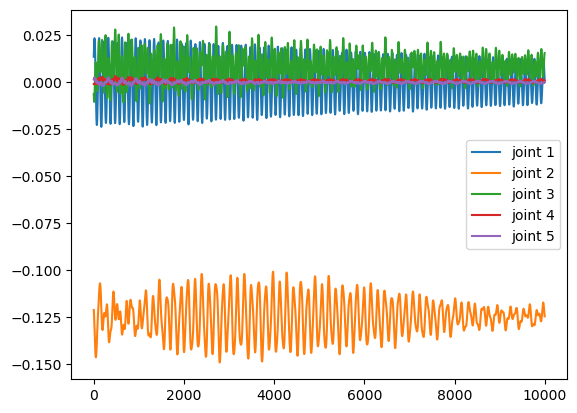

In [13]:
plt.figure()
for j in free_joints:
    plt.plot(log_ang_err[:, j-1], label='joint '+str(j))
plt.legend()

In [14]:
def linear_interpolate_path(start_pos, delta_xyz, interval):
    """
    Plots steps of length 'interval' from 'start_pos' to 'start_pos'+'delta_xyz'
    """
    start_pos = np.array(start_pos).flatten()
    delta_xyz = np.array(delta_xyz).flatten()
    path_len = np.linalg.norm(delta_xyz)
    num_pts = int(np.ceil(path_len / float(interval)))
    if num_pts <= 1:
        num_pts = 2
    waypoints_sp = np.linspace(0, path_len, num_pts).reshape(-1, 1)
    waypoints = start_pos + waypoints_sp / float(path_len) * delta_xyz
    return waypoints

In [15]:
def get_ee_pose():
    info = pybullet.getLinkState(robot, ee_link_id)
    pos = info[4]
    quat = info[5]
    return np.array(pos), np.array(quat)

In [16]:
def to_quat(ori):
    """
    Converts the input rotation format to unit quaternion
    """
    ori = np.array(ori)
    if ori.size == 3:
        # [roll, pitch, yaw]
        ori = euler2quat(ori)
    elif ori.shape == (3, 3):
        ori = rot2quat(ori)
    elif ori.size != 4:
        raise ValueError('Orientation should be rotation matrix, '
                         'euler angles or quaternion')
    return ori

In [17]:
def ang_in_mpi_ppi(angle):
    """
    Restricts the angle within the range [-pi, pi)
    """
    angle = (angle + np.pi) % (2 * np.pi) - np.pi
    return angle

In [18]:
def compute_inverse_kinematics(pos, ori):
    ori = to_quat(ori)
    jnt_poss = pybullet.calculateInverseKinematics(robot, ee_link_id, pos, ori)
    jnt_poss = list(map(ang_in_mpi_ppi, jnt_poss))
    arm_jnt_poss = [jnt_poss[i] for i in range(len(free_joints))]
    return arm_jnt_poss

In [36]:
from observation import getObservation

def set_jpos(position, log=False):
    position = position.copy()
    tgt_pos = position
    pybullet.setJointMotorControlArray(robot, free_joints, pybullet.POSITION_CONTROL,
                                            targetPositions=tgt_pos)
    pybullet.stepSimulation()
    if log:
        ee_positions_x.append(pybullet.getLinkState(robot, ee_link_id)[0][0])
        ee_positions_y.append(pybullet.getLinkState(robot, ee_link_id)[0][1])
        ee_positions_z.append(pybullet.getLinkState(robot, ee_link_id)[0][2])
        p, theta, _ = getObservation(robot, np.linspace(0, 11, 12, dtype=int))
        #pybullet.applyExternalForce(robot, 9, 20*position/np.linalg.norm(position), [0,0,0], 1)
        log_p.append(p)
        log_theta.append(theta)

    time.sleep(timeStep)

#### Send Robot to Desired Initial Position

In [17]:
for i in range(100):
    set_jpos(INITIAL_CONF)

### Take Small Steps to Reach Destination Position

In [37]:
ee_link_id = 7 # Check
delta_xyz = np.array((-1,0,0)) #oscillate between (1,0,0) and (-1,0,0)
eef_step = 0.01

ee_positions_x = []
ee_positions_y = []
ee_positions_z = []
log_p = []
log_theta = []

pos, quat = get_ee_pose()
cur_pos = np.array(pos)
delta_xyz = np.array(delta_xyz)

waypoints = linear_interpolate_path(cur_pos, delta_xyz, eef_step)
way_jnt_positions = []
for i in range(waypoints.shape[0]):
    tgt_jnt_poss = compute_inverse_kinematics(waypoints[i, :].flatten().tolist(), quat)
    way_jnt_positions.append(tgt_jnt_poss.copy())
for jnt_poss in way_jnt_positions:
    sub_steps = 4
    for i in range(1, sub_steps):
        set_jpos(jnt_poss, log=False)
    set_jpos(jnt_poss, log=True)

error: force needs a 3 coordinates [x,y,z].

### Plot Ideal vs Actual Positions of End Effector

[]

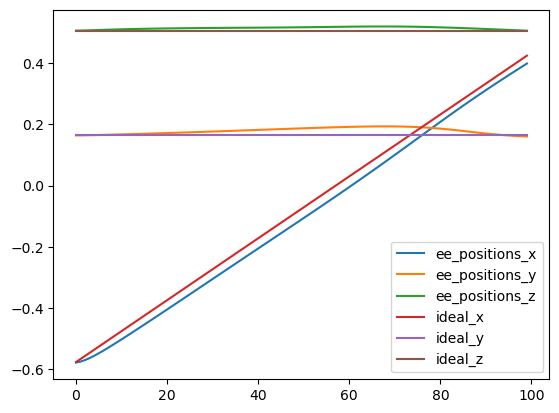

In [31]:
plt.plot(ee_positions_x, label='ee_positions_x')
plt.plot(ee_positions_y, label='ee_positions_y')
plt.plot(ee_positions_z, label='ee_positions_z')

plt.plot(waypoints[:, 0], label='ideal_x')
plt.plot(waypoints[:, 1], label='ideal_y')
plt.plot(waypoints[:, 2], label='ideal_z')

plt.legend()
plt.plot()

[]

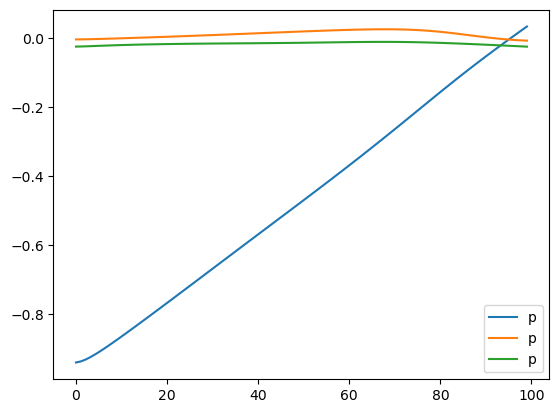

In [32]:
plt.plot(log_p, label='p')

#plt.plot(log_theta, label='theta')

plt.legend()
plt.plot()

[]

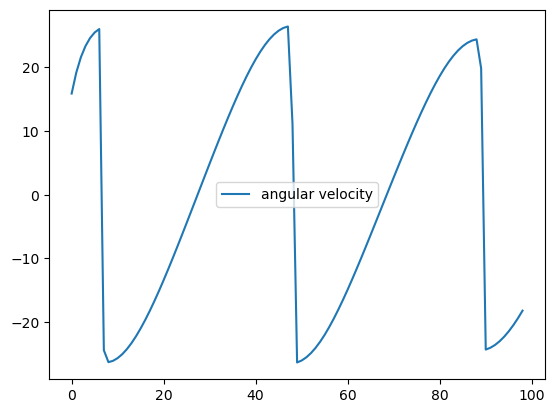

In [33]:
ang_vel = (np.array(np.abs(log_theta)) - np.concatenate((np.array([0]), np.array(np.abs(log_theta[:-1])))))[1:]/timeStep
plt.plot(ang_vel, label='angular velocity')

plt.legend()
plt.plot()

[]

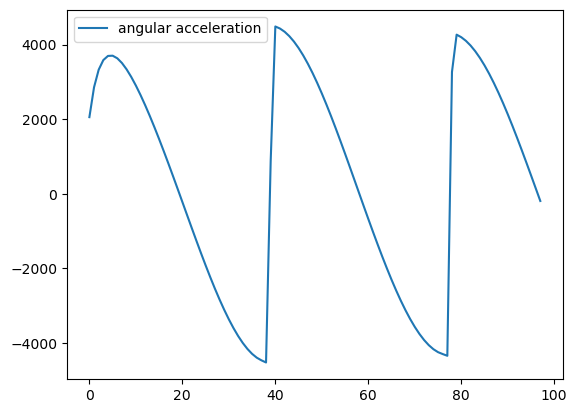

In [28]:
ang_acc = np.array(ang_vel) - np.concatenate((np.array([0]), np.array(ang_vel[:-1])))/timeStep
plt.plot(ang_acc[1:], label='angular acceleration')

plt.legend()
plt.plot()

In [47]:
ang_acc

array([ 3.10256126e+00, -3.10548739e+00,  3.58070641e-05,  3.54803701e-05,
        3.51377343e-05,  3.82560404e-03, -3.46350932e-04, -3.10328603e-04,
       -2.77110999e-04,  3.57685863e-03, -6.06338925e-04, -5.45113954e-04,
       -4.89316389e-04,  3.39671669e-03, -7.82258830e-04, -7.04112678e-04,
       -6.33390094e-04,  3.27585913e-03, -9.02178851e-04, -8.12887022e-04,
       -6.28391758e+00,  6.28637901e+00, -9.84911530e-04, -8.88374626e-04,
       -8.01211353e-04,  3.13668240e-03, -1.04304392e-03, -9.41690114e-04,
       -8.50295770e-04,  3.09495478e-03, -1.08372063e-03, -9.80313127e-04,
       -8.86186012e-04,  3.06475290e-03, -1.11464928e-03, -1.00910878e-03,
       -9.13242660e-04,  3.04189763e-03, -1.13897981e-03, -1.03127305e-03,
       -9.34326620e-04,  3.02232252e-03, -1.15734700e-03, -1.04890915e-03,
       -9.51317644e-04,  3.00516312e-03, -1.17220451e-03, -1.06337352e-03,
       -9.65425240e-04,  2.98925091e-03, -1.18452298e-03, -1.07553602e-03,
       -9.77422460e-04,  

In [18]:
pybullet.disconnect()

#### PD Control Approach

In [ ]:
ee_link_id = 7 # Check
delta_xyz = np.array((-1,0,0)) #oscillate between (1,0,0) and (-1,0,0)
eef_step = 0.01

ee_positions_x = []
ee_positions_y = []
ee_positions_z = []

pos, quat = get_ee_pose()
cur_pos = np.array(pos)
delta_xyz = np.array(delta_xyz)

waypoints = linear_interpolate_path(cur_pos, delta_xyz, eef_step)
way_jnt_positions = []
for i in range(waypoints.shape[0]):
    tgt_jnt_poss = compute_inverse_kinematics(waypoints[i, :].flatten().tolist(), quat)
    way_jnt_positions.append(tgt_jnt_poss.copy())
for jnt_poss in way_jnt_positions:
    sub_steps = 4
    for i in range(1, sub_steps):
        set_jpos(jnt_poss, log=False)
    set_jpos(jnt_poss, log=True)

In [5]:
import pandas as pd
import numpy as np

df = pd.DataFrame({'applicants':[], 'men':[], 'women':[]})

In [8]:
m_applicants = np.array([825,560,325,417,191,373])
m_perc_admit = np.array([62, 63,37,33,28,6])/100.

m_admits = m_applicants*m_perc_admit

In [9]:
f_applicants = np.array([108, 25, 593, 375, 393, 341])
f_perc_admit = np.array([82, 68, 34, 35, 24, 7])/100.

f_admits = f_applicants*f_perc_admit

In [12]:
m_admits, f_admits, np.round(m_admits), np.round(f_admits)

(array([511.5 , 352.8 , 120.25, 137.61,  53.48,  22.38]),
 array([ 88.56,  17.  , 201.62, 131.25,  94.32,  23.87]),
 array([512., 353., 120., 138.,  53.,  22.]),
 array([ 89.,  17., 202., 131.,  94.,  24.]))

In [13]:
net_m_perc_admit = np.sum(np.round(m_admits))/np.sum(m_applicants)
net_f_perc_admit = np.sum(np.round(f_admits))/np.sum(f_applicants)

In [14]:
net_m_perc_admit, net_f_perc_admit

(0.4451876625789669, 0.30354223433242505)

In [16]:
np.sum(np.round(f_admits))/np.sum(np.round(m_admits))

0.46494156928213687